## 1.

Propensity Score Matching: Comparing Cognitive Function Between First-episode and Chronic Patients
Rows after removing missing values: 211 (original rows: 211)

Classifying patients based on illness duration:
First-episode patients: illness duration <= 2 years
Chronic patients: illness duration > 2 years
First-episode group (≤2 years): 103
Chronic group (>2 years): 108

Calculating propensity scores using the following covariates:
gender, education, olanzapine_dose, age_of_onset

Propensity Score Model Results:
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0586      0.549     -0.107      0.915      -1.134       1.017
gender              0.4467      0.328      1.363      0.173      -0.196       1.089
education          -0.1895      0.120     -1.580      0.114      -0.425       0.046
olanzapine_dose     0.7681      0.173      4.433      0.000    

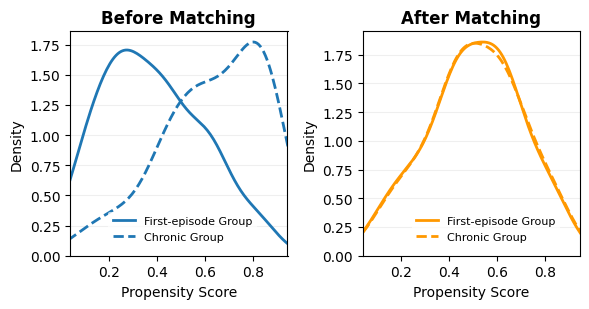

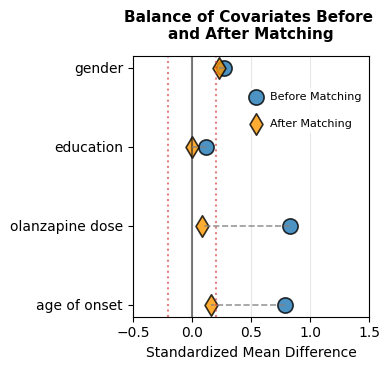

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import ttest_ind
import warnings
import os

# 创建目录存储结果
os.makedirs('./image', exist_ok=True)
os.makedirs('./table', exist_ok=True)

warnings.filterwarnings('ignore')

def read_data():
    """Read Excel data file"""
    try:
        df = pd.read_excel('data.xlsx')
        return df
    except Exception as e:
        print(f"Error reading data: {e}")
        return None

def prepare_data(df):
    """Prepare data for analysis"""
    # 检查必要列是否存在
    required_cols = [
        'EprimeID2back ',
        'Dose Equivalent to Olanzapine (mg/d)', 
        'Reaction time at 2-back task',
        'd-prime score at 2-back task',
        'Accuracy at 1750 ms',
        'Accuracy at 750 ms',
        'Age',  # 添加年龄列
        'Gender',
        'Education level',
        'Course of illness',
        'PANSS-P',
        'PANSS-N',
        'PANSS-GP',
        'PANSS-T',        
        'Age of onset',
    ]
    
    # 创建工作数据集
    analysis_df = df[required_cols].copy()
    
    # 重命名列以便使用
    analysis_df.columns = [
        'EprimeID2back ',
        'olanzapine_dose', 
        'reaction_time',
        'd-prime',
        'Accuracy_at_1750 ms',
        'Accuracy_at_750 ms',
        'age',  # 添加年龄列
        'gender',
        'education',
        'illness_duration',
        'panss_p',
        'panss_n',
        'panss_gp',
        'panss_total',  
        'age_of_onset'
    ]
    
    # 处理缺失值
    analysis_df_clean = analysis_df.dropna()
    print(f"Rows after removing missing values: {len(analysis_df_clean)} (original rows: {len(analysis_df)})")
    return analysis_df_clean

def create_illness_groups(df):
    threshold = 2  # 2年作为阈值
    
    print(f"\nClassifying patients based on illness duration:")
    print(f"First-episode patients: illness duration <= {threshold} years")
    print(f"Chronic patients: illness duration > {threshold} years")
    
    df['chronic_patient'] = (df['illness_duration'] > threshold).astype(int)
    
    # 显示每组样本量
    print(f"First-episode group (≤{threshold} years): {sum(df['chronic_patient'] == 0)}")
    print(f"Chronic group (>{threshold} years): {sum(df['chronic_patient'] == 1)}")
    
    return df, threshold

def calculate_propensity_scores(df, covariates=None):
    if covariates is None:
        # 修改这里，只使用真正的混杂因素，不包括PANSS
        covariates = ['gender', 'education', 'olanzapine_dose', 'age_of_onset']
    
    print(f"\nCalculating propensity scores using the following covariates:")
    print(", ".join(covariates))
    
    # 准备数据
    X = df[covariates].copy()
    y = df['chronic_patient']
    
    # 标准化连续变量（排除分类变量）
    continuous_vars = [var for var in covariates if var not in ['gender', 'education']]
    scaler = StandardScaler()
    X[continuous_vars] = scaler.fit_transform(X[continuous_vars])
    
    # 拟合逻辑回归模型
    model = LogisticRegression(random_state=42)
    model.fit(X, y)
    
    # 计算倾向性评分
    propensity_scores = model.predict_proba(X)[:, 1]
    df['propensity_score'] = propensity_scores
    
    # 打印逻辑回归模型结果
    X_with_const = sm.add_constant(X)
    logit_model = sm.Logit(y, X_with_const)
    result = logit_model.fit(disp=0)
    print("\nPropensity Score Model Results:")
    print(result.summary().tables[1])
    
    return df

def plot_propensity_score_distribution(df_before, df_after, save_path='./image/propensity_score_distribution.jpg'):
    """Plot propensity score distribution before and after matching as curves"""
    # 创建一个1x2的子图布局
    fig, axes = plt.subplots(1, 2, figsize=(6, 3.2), sharex=True)
    
    # 匹配前的曲线图
    sns.kdeplot(
        data=df_before[df_before['chronic_patient'] == 0], 
        x='propensity_score', 
        shade=False, 
        color='#1f77b4', 
        alpha=0.7, 
        ax=axes[0], 
        label='First-episode Group', 
        linewidth=2
    )
    sns.kdeplot(
        data=df_before[df_before['chronic_patient'] == 1], 
        x='propensity_score', 
        shade=False, 
        color='#1f77b4', 
        alpha=0.7, 
        ax=axes[0], 
        label='Chronic Group', 
        linewidth=2, 
        linestyle='--'
    )
    axes[0].set_title('Before Matching', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Propensity Score')
    axes[0].set_ylabel('Density')
    axes[0].legend(loc='upper left', frameon=True, framealpha=0.7, edgecolor='none', fontsize=8, ncol=1, bbox_to_anchor=(0.15, 0.22))
    
    # 设置相同的X轴范围
    x_min = min(df_before['propensity_score'].min(), df_after['propensity_score'].min())
    x_max = max(df_before['propensity_score'].max(), df_after['propensity_score'].max())
    axes[0].set_xlim(x_min, x_max)
    axes[1].set_xlim(x_min, x_max)
    
    # 匹配后的曲线图
    sns.kdeplot(
        data=df_after[df_after['chronic_patient'] == 0], 
        x='propensity_score', 
        shade=False, 
        color='#ff9800', 
        alpha=0.7, 
        ax=axes[1], 
        label='First-episode Group', 
        linewidth=2
    )
    sns.kdeplot(
        data=df_after[df_after['chronic_patient'] == 1], 
        x='propensity_score', 
        shade=False, 
        color='#ff9800', 
        alpha=0.7, 
        ax=axes[1], 
        label='Chronic Group', 
        linewidth=2, 
        linestyle='--'
    )
    axes[1].set_title('After Matching', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Propensity Score')
    axes[1].set_ylabel('Density')
    axes[1].legend(loc='upper left', frameon=True, framealpha=0.7, edgecolor='none', fontsize=8, ncol=1, bbox_to_anchor=(0.2, 0.22))
    
    # 添加网格线
    axes[0].grid(axis='y', alpha=0.2)
    axes[1].grid(axis='y', alpha=0.2)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=1200, bbox_inches='tight')
    plt.show()

def match_samples(df, caliper=0.25, gender_strict=False, education_tolerance=0):
    """
    Perform propensity score matching.
    
    Parameters:
      - caliper: 卡尺系数，用于限制倾向性评分差异
      - gender_strict: 若为True，则要求匹配时性别完全一致；若为False，则不对性别进行筛选
      - education_tolerance: 若为数字，则要求匹配时教育水平差值不超过该值；
                             若为None则不进行教育匹配。
                             （设为0时表示教育水平必须完全一致，实现更严格匹配）
    """
    ps_std = df['propensity_score'].std()
    caliper_value = caliper * ps_std
    
    print(f"\nPerforming propensity score matching (caliper={caliper}*std={caliper_value:.3f})")
    
    df_copy = df.copy()
    df_copy['matched'] = 0
    
    treated = df_copy[df_copy['chronic_patient'] == 1].copy().reset_index(drop=True)
    control = df_copy[df_copy['chronic_patient'] == 0].copy().reset_index(drop=True)
    
    treated['matched_idx'] = -1
    matched_indices = []
    
    for t_idx, treated_row in treated.iterrows():
        ps_treated = treated_row['propensity_score']
        # 仅选择尚未匹配的对照样本，避免重复匹配
        eligible_controls = control[control['matched'] == 0].copy()
        # 根据参数调节匹配严格程度
        if gender_strict:
            eligible_controls = eligible_controls[eligible_controls['gender'] == treated_row['gender']]
        if education_tolerance is not None:
            # 假定education为数值型，设容忍度为0时表示要求完全一致
            eligible_controls = eligible_controls[abs(eligible_controls['education'] - treated_row['education']) <= education_tolerance]
        
        if eligible_controls.empty:
            continue
        
        eligible_controls['ps_diff'] = abs(eligible_controls['propensity_score'] - ps_treated)
        eligible_controls = eligible_controls[eligible_controls['ps_diff'] <= caliper_value]
        
        if len(eligible_controls) > 0:
            best_match_idx = eligible_controls['ps_diff'].idxmin()
            treated.at[t_idx, 'matched'] = 1
            treated.at[t_idx, 'matched_idx'] = best_match_idx
            control.at[best_match_idx, 'matched'] = 1
            matched_indices.append((t_idx, best_match_idx))
            control.at[best_match_idx, 'ps_diff'] = float('inf')
    
    matched_treated = treated[treated['matched'] == 1].copy()
    matched_control = control.loc[matched_treated['matched_idx']].copy().reset_index(drop=True)
    matched_df = pd.concat([matched_treated, matched_control]).reset_index(drop=True)
    
    n_treated = len(treated)
    n_matched_treated = len(matched_treated)
    match_rate = n_matched_treated / n_treated * 100
    
    print(f"Chronic patient group sample size: {n_treated}")
    print(f"Successfully matched samples: {n_matched_treated}")
    print(f"Match rate: {match_rate:.2f}%")
    
    pairs_df = pd.DataFrame({
        'treated_idx': [pair[0] for pair in matched_indices],
        'control_idx': [pair[1] for pair in matched_indices],
        'treated_ps': matched_treated['propensity_score'].values,
        'control_ps': matched_control['propensity_score'].values,
        'ps_diff': abs(matched_treated['propensity_score'].values - matched_control['propensity_score'].values)
    })
    pairs_df.to_csv('./table/matched_pairs.csv', index=False)
    matched_df.to_excel('./table/matched_data.xlsx', index=False)
    
    return matched_df

def assess_balance(df_original, df_matched):
    """Assess balance before and after matching"""
    covariates = [
        'age', 'gender', 'education', 'illness_duration',
        'panss_p', 'panss_n', 'panss_gp', 'panss_total',
        'olanzapine_dose', 'age_of_onset'
    ]
    
    balance_results = []
    
    print("\nBalance assessment before and after matching:")
    print("=" * 100)
    print(f"{'Variable':<15} | {'Before Matching':<45} | {'After Matching':<45}")
    print(f"{'':<15} | {'First-episode':>15} {'Chronic':>15} {'p':>6} {'SMD':>6} | {'First-episode':>15} {'Chronic':>15} {'p':>6} {'SMD':>6}")
    print("-" * 100)
    
    for var in covariates:
        # 对于分类变量：gender 和 education
        if var in ['gender', 'education']:
            table_before = pd.crosstab(df_original['chronic_patient'], df_original[var])
            _, p_before, _, _ = stats.chi2_contingency(table_before)
            # 对于 education，固定选取类别1；而 gender 仍采用众数作为参考类别
            if var == 'education':
                common_cat = 1
            else:
                common_cat = df_original[var].mode()[0]
            prop0_before = df_original[df_original['chronic_patient'] == 0][var].eq(common_cat).mean()
            prop1_before = df_original[df_original['chronic_patient'] == 1][var].eq(common_cat).mean()
            first_episode_before = f"{prop0_before*100:.1f}% ({common_cat})"
            chronic_before = f"{prop1_before*100:.1f}% ({common_cat})"
            var_denom_before = (prop0_before*(1-prop0_before) + prop1_before*(1-prop1_before)) / 2
            smd_before = abs(prop1_before - prop0_before) / np.sqrt(var_denom_before) if var_denom_before > 0 else 0
            
            table_after = pd.crosstab(df_matched['chronic_patient'], df_matched[var])
            _, p_after, _, _ = stats.chi2_contingency(table_after)
            prop0_after = df_matched[df_matched['chronic_patient'] == 0][var].eq(common_cat).mean()
            prop1_after = df_matched[df_matched['chronic_patient'] == 1][var].eq(common_cat).mean()
            first_episode_after = f"{prop0_after*100:.1f}% ({common_cat})"
            chronic_after = f"{prop1_after*100:.1f}% ({common_cat})"
            var_denom_after = (prop0_after*(1-prop0_after) + prop1_after*(1-prop1_after)) / 2
            smd_after = abs(prop1_after - prop0_after) / np.sqrt(var_denom_after) if var_denom_after > 0 else 0
        else:
            group0_before = df_original[df_original['chronic_patient'] == 0][var]
            group1_before = df_original[df_original['chronic_patient'] == 1][var]
            mean0_before = group0_before.mean()
            mean1_before = group1_before.mean()
            sd_pooled_before = np.sqrt((group0_before.var() + group1_before.var()) / 2)
            smd_before = abs(mean1_before - mean0_before) / sd_pooled_before if sd_pooled_before > 0 else 0
            _, p_before = ttest_ind(group0_before, group1_before, equal_var=False)
            first_episode_before = f"{mean0_before:.2f}±{group0_before.std():.2f}"
            chronic_before = f"{mean1_before:.2f}±{group1_before.std():.2f}"
            
            group0_after = df_matched[df_matched['chronic_patient'] == 0][var]
            group1_after = df_matched[df_matched['chronic_patient'] == 1][var]
            mean0_after = group0_after.mean()
            mean1_after = group1_after.mean()
            sd_pooled_after = np.sqrt((group0_after.var() + group1_after.var()) / 2)
            smd_after = abs(mean1_after - mean0_after) / sd_pooled_after if sd_pooled_after > 0 else 0
            _, p_after = ttest_ind(group0_after, group1_after, equal_var=False)
            first_episode_after = f"{mean0_after:.2f}±{group0_after.std():.2f}"
            chronic_after = f"{mean1_after:.2f}±{group1_after.std():.2f}"
        
        improvement = (smd_before - smd_after) / smd_before * 100 if smd_before > 0 else 0
        
        p_before_str = f"{p_before:.3f}"
        p_after_str = f"{p_after:.3f}"
        if p_before < 0.05:
            p_before_str += "*"
        if p_before < 0.01:
            p_before_str += "*"
        if p_before < 0.001:
            p_before_str += "*"
        if p_after < 0.05:
            p_after_str += "*"
        if p_after < 0.01:
            p_after_str += "*"
        if p_after < 0.001:
            p_after_str += "*"
        
        print(f"{var:<15} | {first_episode_before:>15} {chronic_before:>15} {p_before_str:>6} {smd_before:>6.3f} | {first_episode_after:>15} {chronic_after:>15} {p_after_str:>6} {smd_after:>6.3f}")
        
        balance_results.append({
            'Variable': var,
            'First_episode_Before': first_episode_before,
            'Chronic_Before': chronic_before,
            'SMD_Before': smd_before,
            'p_Before': p_before,
            'First_episode_After': first_episode_after,
            'Chronic_After': chronic_after, 
            'SMD_After': smd_after,
            'p_After': p_after,
            'Improvement': improvement
        })
    
    print("=" * 100)
    print("* p<0.05, ** p<0.01, *** p<0.001")
    
    balance_df = pd.DataFrame(balance_results)
    balance_df.to_csv('./table/balance_assessment.csv', index=False)
    
    return balance_df

def compare_outcomes(df_matched):
    """Compare outcome variables between matched groups, including an analysis controlling for age"""
    outcome_var = 'reaction_time'
    
    # 原始的未调整比较（t检验）
    group0 = df_matched[df_matched['chronic_patient'] == 0][outcome_var]
    group1 = df_matched[df_matched['chronic_patient'] == 1][outcome_var]
    
    t_stat, p_value = ttest_ind(group0, group1, equal_var=False)
    
    print(f"\nOutcome comparison after matching - {outcome_var} (unadjusted):")
    print(f"First-episode group: {group0.mean():.2f} ± {group0.std():.2f}")
    print(f"Chronic group: {group1.mean():.2f} ± {group1.std():.2f}")
    print(f"Mean difference: {group1.mean() - group0.mean():.2f}")
    print(f"t-test: t={t_stat:.3f}, p={p_value:.3f}")
    
    # 增加控制Age的线性回归模型
    formula = f"{outcome_var} ~ chronic_patient + age"
    model = smf.ols(formula, data=df_matched).fit()
    
    print("\nOutcome comparison after matching (controlling for age) using linear regression:")
    print(model.summary())
    
    coef = model.params['chronic_patient']
    p_val_reg = model.pvalues['chronic_patient']
    conf_int = model.conf_int().loc['chronic_patient'].tolist()
    print(f"Effect of chronic_patient (controlling for age): Coefficient = {coef:.3f}, 95% CI = [{conf_int[0]:.3f}, {conf_int[1]:.3f}], p-value = {p_val_reg:.3f}")
    
    return {
        'unadjusted': {
            'mean_first_episode': group0.mean(),
            'std_first_episode': group0.std(),
            'mean_chronic': group1.mean(),
            'std_chronic': group1.std(),
            'mean_diff': group1.mean() - group0.mean(),
            't_stat': t_stat,
            'p_value': p_value
        },
        'adjusted': {
            'coef_chronic_patient': coef,
            'p_value': p_val_reg,
            'conf_int': conf_int
        }
    }

def plot_love(balance_df, save_path='./image/love_plot.jpg'):
    # Filter out部分变量
    filtered_df = balance_df[~balance_df['Variable'].isin([
        'illness_duration', 'panss_p', 'panss_n', 'panss_gp', 'panss_total', 'age'
    ])].copy()

    variables = filtered_df['Variable'].tolist()
    smd_before = filtered_df['SMD_Before'].tolist()
    smd_after = filtered_df['SMD_After'].tolist()

    variables.reverse()
    smd_before.reverse()
    smd_after.reverse()
    variables = [var.replace('_', ' ') for var in variables]

    fig, ax = plt.subplots(figsize=(4, 3.8))
    
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    ax.axvline(x=0.2, color='#d32f2f', linestyle=':', alpha=0.6)
    ax.axvline(x=-0.2, color='#d32f2f', linestyle=':', alpha=0.6)

    ax.scatter(smd_before, variables, marker='o', s=120, color='#1f77b4', alpha=0.8, label='Before Matching', edgecolors='black', linewidth=1.2)
    ax.scatter(smd_after, variables, marker='d', s=120, color='#ff9800', alpha=0.8, label='After Matching', edgecolors='black', linewidth=1.2)
    
    for i in range(len(variables)):
        ax.plot([smd_before[i], smd_after[i]], [variables[i], variables[i]], color='gray', alpha=0.8, linestyle='--', lw=1.2)

    ax.set_xlabel('Standardized Mean Difference', fontsize=10)
    ax.set_title('Balance of Covariates Before \nand After Matching', fontsize=11, fontweight='bold', pad=12)
    ax.set_xlim(-0.5, 1.5)
    ax.grid(axis='x', alpha=0.3)
    
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticks(np.arange(-0.5, 1.6, 0.5))
    ax.set_yticklabels(variables, fontsize=10)
    
    ax.legend(loc='upper left', fontsize=8, frameon=True, framealpha=0.8, edgecolor='none',
              bbox_to_anchor=(0.43, 0.9), ncol=1, columnspacing=50, handletextpad=0.3, labelspacing=1.5)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=1200, bbox_inches='tight')
    plt.show()

def main():
    """Main function"""
    print("="*80)
    print("Propensity Score Matching: Comparing Cognitive Function Between First-episode and Chronic Patients")
    print("="*80)
    
    # 1. 读取数据
    df = read_data()
    if df is None:
        return
    
    # 2. 准备数据
    df_clean = prepare_data(df)
    if df_clean is None:
        return
    
    # 3. 创建首发/慢性患者组
    df_binary, threshold = create_illness_groups(df_clean)
    
    # 4. 计算倾向性评分（只使用真正的混杂因素）
    df_with_ps = calculate_propensity_scores(df_binary)
    
    # 保存匹配前的数据，用于后续绘图
    df_before_matching = df_with_ps.copy()
    
    # 5. 倾向性评分匹配
    df_matched = match_samples(df_with_ps, caliper=0.2, gender_strict=False, education_tolerance=0)
    
    # 6. 评估匹配后的平衡性
    balance_df = assess_balance(df_binary, df_matched)
    
    # 7. 比较主要结局（反应时间）的匹配后差异，并控制年龄
    outcome_results = compare_outcomes(df_matched)
    
    # 8. 绘制匹配前后倾向性评分分布对比图
    plot_propensity_score_distribution(df_before_matching, df_matched)
    
    # 9. 绘制Love图
    plot_love(balance_df)
    
if __name__ == "__main__":
    main()

匹配后样本中病程与发病年龄的 Pearson 相关系数：
相关系数：-0.118, p-value：0.224


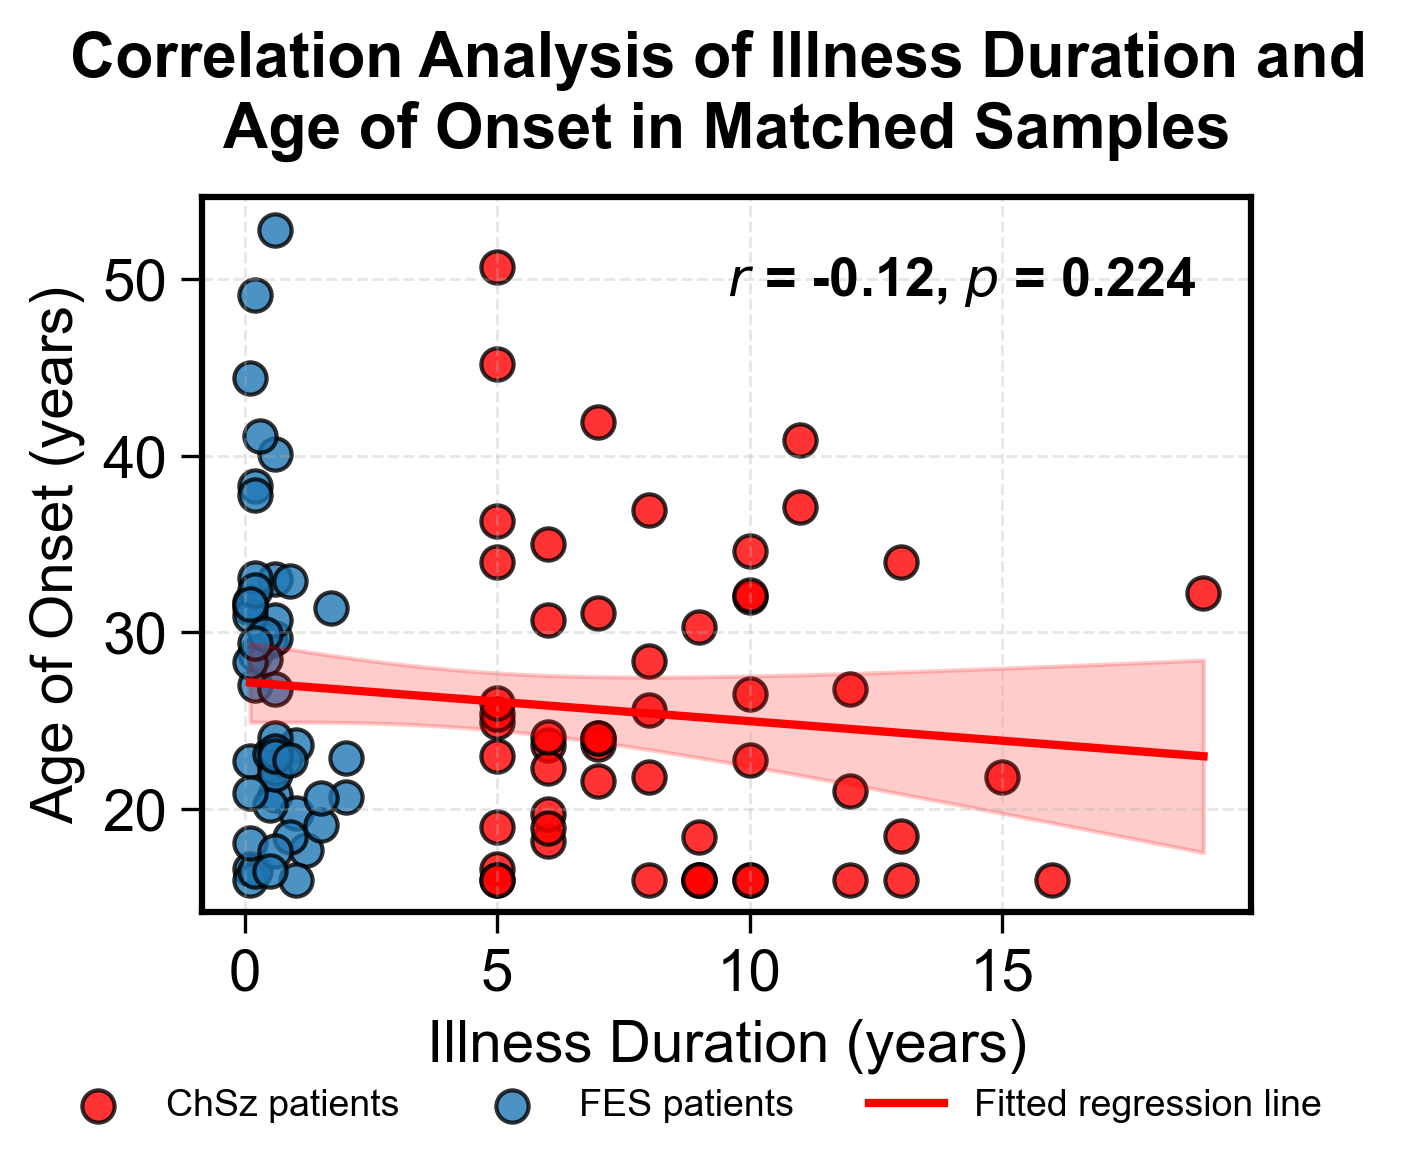

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, t

# 设置全局绘图参数，符合高质量期刊图形要求
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'Arial',
    'axes.linewidth': 1.5,
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'figure.dpi': 300,
    'legend.frameon': False,
    'savefig.bbox': 'tight'
})

# 读取匹配后的数据
df_matched = pd.read_excel('./table/matched_data.xlsx')

# 计算 illness_duration 与 age_of_onset 的 Pearson 相关系数
corr_coef, p_value = pearsonr(df_matched['illness_duration'], df_matched['age_of_onset'])
print("匹配后样本中病程与发病年龄的 Pearson 相关系数：")
print(f"相关系数：{corr_coef:.3f}, p-value：{p_value:.3f}")

# 创建绘图对象
fig, ax = plt.subplots(figsize=(4.8, 4.3))

# 根据 chronic_patient 的值绘制不同的散点图：
# 如果 chronic_patient 为 1，则使用 marker 'x'；为 0 则使用 marker 'o'
df_chronic1 = df_matched[df_matched['chronic_patient'] == 1]
df_chronic0 = df_matched[df_matched['chronic_patient'] == 0]

ax.scatter(df_chronic1['illness_duration'], df_chronic1['age_of_onset'],
           marker='o', s=60, edgecolor='k', facecolor='red', alpha=0.8, label='ChSz patients')
ax.scatter(df_chronic0['illness_duration'], df_chronic0['age_of_onset'],
           marker='o', s=60, edgecolor='k', facecolor='#1f77b4', alpha=0.8, label='FES patients')

# 拟合直线：使用最小二乘法
x = np.array(df_matched['illness_duration'])
y = np.array(df_matched['age_of_onset'])
n = len(x)
slope, intercept = np.polyfit(x, y, 1)
x_line = np.linspace(np.min(x), np.max(x), 100)
y_line = intercept + slope * x_line

# 计算均方误差（MSE）
y_pred = intercept + slope * x
mse = np.sum((y - y_pred)**2) / (n - 2)

# 计算 95% 置信区间
mean_x = np.mean(x)
Sxx = np.sum((x - mean_x)**2)
t_val = t.ppf(1 - 0.025, df=n - 2)  # 双尾检验
se_line = np.sqrt(mse * (1/n + (x_line - mean_x)**2 / Sxx))
y_upper = y_line + t_val * se_line
y_lower = y_line - t_val * se_line

# 绘制拟合直线和置信区间
ax.plot(x_line, y_line, color='red', linewidth=2, label='Fitted regression line')
ax.fill_between(x_line, y_lower, y_upper, color='red', alpha=0.2)

# 设置标题和坐标轴标签
ax.set_title('Correlation Analysis of Illness Duration and \nAge of Onset in Matched Samples', fontsize=15, fontweight='bold', pad=12)
ax.set_xlabel('Illness Duration (years)', fontsize=14)
ax.set_ylabel('Age of Onset (years)', fontsize=14)

# 添加网格，使用虚线提高图形美观度
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.3)

# 在图内添加文本框标注相关系数、p-value 及样本量
annotation_text = f'$r$ = {corr_coef:.2f}, $p$ = {p_value:.3f}'
props = dict(boxstyle='round', facecolor='none', edgecolor='none', alpha=0.8)
ax.text(0.50, 0.92, annotation_text, transform=ax.transAxes, fontsize=13,fontweight='bold',
        verticalalignment='top', bbox=props)

plt.legend(loc='best', fontsize=9,bbox_to_anchor=(1.1, -0.20),ncol=3)
plt.tight_layout()

# 保存图像
save_path = './image/matched_data.jpg'
plt.savefig(save_path, dpi=1200, bbox_inches='tight')
plt.show()

## 2.

数据列名： ['ID', 'EprimeID1750', 'EprimeID2back ', 'Reaction time at 2-back task', 'Dose Equivalent to Olanzapine (mg/d)', 'Age', 'Gender', 'Education level', 'Accuracy at 1750 ms', 'Accuracy at 750 ms', 'Course of illness', 'Group', 'PANSS-P', 'PANSS-N', 'PANSS-GP', 'PANSS-T', 'Age of onset', 'd-prime score at 2-back task', 'Hit Rate', 'False Alarm Rate', 'Hits', 'False Alarms']

--- Statsmodels 分步回归 ---
中介模型 (M ~ X) 结果：
                            OLS Regression Results                            
Dep. Variable:           Q("PANSS-T")   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     8.557
Date:                Wed, 26 Mar 2025   Prob (F-statistic):            0.00382
Time:                        10:59:02   Log-Likelihood:                -820.60
No. Observations:                 211   AIC:                             1645.
Df Residuals:            

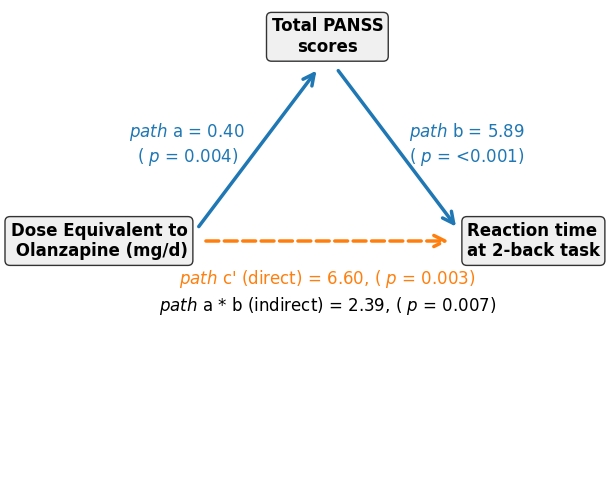

In [9]:
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt  # 新增可视化包

# 定义一个辅助函数，用于格式化 p 值
def fmt_p(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

# 读取 Excel 文件
df = pd.read_excel('data.xlsx')

# 查看数据的列名，确保与代码中变量名一致
print("数据列名：", df.columns.tolist())

# --------------------- 分步回归分析 ---------------------
print("\n--- Statsmodels 分步回归 ---")
# 步骤 1：检验自变量对中介变量的影响
model_m = smf.ols('Q("PANSS-T") ~ Q("Dose Equivalent to Olanzapine (mg/d)")', data=df).fit()
print("中介模型 (M ~ X) 结果：")
print(model_m.summary())

# 步骤 2：检验自变量和中介变量对因变量的影响
model_y = smf.ols('Q("Reaction time at 2-back task") ~ Q("Dose Equivalent to Olanzapine (mg/d)") + Q("PANSS-T")', data=df).fit()
print("\n因变量模型 (Y ~ X + M) 结果：")
print(model_y.summary())

# 计算回归系数及对应的 p 值
a_coef = model_m.params['Q("Dose Equivalent to Olanzapine (mg/d)")']
p_value_a = model_m.pvalues['Q("Dose Equivalent to Olanzapine (mg/d)")']

b_coef = model_y.params['Q("PANSS-T")']
p_value_b = model_y.pvalues['Q("PANSS-T")']

direct_effect = model_y.params['Q("Dose Equivalent to Olanzapine (mg/d)")']
p_value_c = model_y.pvalues['Q("Dose Equivalent to Olanzapine (mg/d)")']

# 计算间接效应（即 X -> M 的回归系数 * M -> Y 的回归系数）
indirect_effect = a_coef * b_coef
print("\n间接效应 (Indirect Effect) = {:.4f}".format(indirect_effect))
print("直接效应 (Direct Effect) = {:.4f}".format(direct_effect))
total_effect = direct_effect + indirect_effect
print("总效应 (Total Effect) = {:.4f}".format(total_effect))

# 使用 bootstrap 方法计算间接效应的置信区间和 p 值
def bootstrap_indirect_effect(data, n_boot=5000, seed=42):
    np.random.seed(seed)
    boot_effects = []
    n = len(data)
    for i in range(n_boot):
        sample = data.sample(n, replace=True)
        # 重新拟合模型
        mod_m = smf.ols('Q("PANSS-T") ~ Q("Dose Equivalent to Olanzapine (mg/d)")', data=sample).fit()
        mod_y = smf.ols('Q("Reaction time at 2-back task") ~ Q("Dose Equivalent to Olanzapine (mg/d)") + Q("PANSS-T")', data=sample).fit()
        a = mod_m.params['Q("Dose Equivalent to Olanzapine (mg/d)")']
        b = mod_y.params['Q("PANSS-T")']
        boot_effects.append(a * b)
    lower = np.percentile(boot_effects, 2.5)
    upper = np.percentile(boot_effects, 97.5)
    boot_effects = np.array(boot_effects)
    # 计算 p 值：双尾检验，即取 boot 样本中与 0 方向相反的比例的两倍
    p_value_indirect = 2 * min(np.mean(boot_effects < 0), np.mean(boot_effects > 0))
    p_value_indirect = min(p_value_indirect, 1.0)  # p 值不超过1
    return indirect_effect, lower, upper, p_value_indirect

indirect, ci_lower, ci_upper, p_value_indirect = bootstrap_indirect_effect(df, n_boot=5000, seed=42)
print("\nBootstrap 置信区间 (95%) 的间接效应: {:.4f} [{:.4f}, {:.4f}]".format(indirect, ci_lower, ci_upper))
print("间接效应的 p 值: {}".format(fmt_p(p_value_indirect)))


# --------------------- 病程作为调节变量的交互效应 ---------------------

# 创建病程类别变量
df['病程类别'] = df['Group'].map({1: 'Group1', 2: 'Group2'})
# 步骤 1：检验自变量与病程类别的交互作用对中介变量的影响
model_m_interaction = smf.ols('Q("PANSS-T") ~ Q("Dose Equivalent to Olanzapine (mg/d)") * C(病程类别)', data=df).fit()
print("\n包含病程调节效应的中介模型 (M ~ X * C(病程类别)) 结果：")
print(model_m_interaction.summary())

# 步骤 2：检验自变量、中介变量和病程调节效应对因变量的影响
model_y_interaction = smf.ols('Q("Reaction time at 2-back task") ~ Q("Dose Equivalent to Olanzapine (mg/d)") + Q("PANSS-T") * C(病程类别)', data=df).fit()
print("\n包含病程调节效应的因变量模型 (Y ~ X + M * C(病程类别)) 结果：")
print(model_y_interaction.summary())


# --------------------- 可视化路径图 ---------------------

plt.figure(figsize=(6, 6))

# 定义节点位置（使用比例坐标）
positions = {
    'X': (0.2, 0.5),
    'M': (0.5, 0.9),
    'Y': (0.8, 0.5)
}

# 配色方案
arrow_color = "#1f77b4"
direct_arrow_color = "#ff7f0e"
node_facecolor = "#f0f0f0"
node_edgecolor = "#333333"

# 箭头样式
arrow_style = dict(arrowstyle='->', connectionstyle="arc3",
                   linewidth=2.5, mutation_scale=20, shrinkA=13, shrinkB=13,
                   color=arrow_color)
arrow_style_direct = arrow_style.copy()
arrow_style_direct['linestyle'] = '--'
arrow_style_direct['color'] = direct_arrow_color

# 绘制路径箭头
plt.annotate('', xy=positions['M'], xytext=positions['X'], arrowprops=arrow_style)
plt.annotate('', xy=positions['Y'], xytext=positions['M'], arrowprops=arrow_style)
plt.annotate('', xy=positions['Y'], xytext=positions['X'], arrowprops=arrow_style_direct)

# 添加节点标签
plt.text(positions['X'][0], positions['X'][1],
         'Dose Equivalent to\n Olanzapine (mg/d)',
         ha='right', va='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.3', fc=node_facecolor, ec=node_edgecolor))
plt.text(positions['M'][0], positions['M'][1], 'Total PANSS\nscores',
         ha='center', va='bottom', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.3', fc=node_facecolor, ec=node_edgecolor))
plt.text(positions['Y'][0], positions['Y'][1],
         'Reaction time\nat 2-back task',
         ha='left', va='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.3', fc=node_facecolor, ec=node_edgecolor))

# 在路径图中标注回归系数及 p 值
# X -> M 路径
plt.text((positions['X'][0] + positions['M'][0]) / 2 - 0.15,
         (positions['X'][1] + positions['M'][1]) / 2 + 0.06,
         f'$path$ a = {a_coef:.2f} \n( $p$ = {fmt_p(p_value_a)})',
         ha='center', va='top', fontsize=12, color=arrow_color)
# M -> Y 路径
plt.text((positions['M'][0] + positions['Y'][0]) / 2 + 0.15,
         (positions['M'][1] + positions['Y'][1]) / 2 + 0.06,
         f'$path$ b = {b_coef:.2f}\n( $p$ = {fmt_p(p_value_b)})',
         ha='center', va='top', fontsize=12, color=arrow_color)
# X -> Y 路径（直接效应）
plt.text((positions['X'][0] + positions['Y'][0]) / 2,
         (positions['X'][1] + positions['Y'][1]) / 2 - 0.105,
         f"$path$ c' (direct) = {direct_effect:.2f}, ( $p$ = {fmt_p(p_value_c)})",
         ha='center', va='bottom', fontsize=12, color=direct_arrow_color)

# 添加间接效应及置信区间和 p 值说明
plt.text(0.5, 0.36,
         f'$path$ a * b (indirect) = {indirect_effect:.2f}, ( $p$ = {fmt_p(p_value_indirect)})',
         ha='center', va='center', fontsize=12)

# 设置坐标轴范围和隐藏坐标轴
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

# 可选：设置背景色
ax = plt.gca()
ax.set_facecolor("white")

# 保存图片
plt.savefig('./image/mediation_analysis_with_moderator药物-->症状-->认知，中介分析.jpg', dpi=1200, bbox_inches='tight')
plt.show()